<a href="https://colab.research.google.com/github/debashisdotchatterjee/Directional-Enhanced-Arrhythmia-Detection-in-ECG-Signals/blob/main/MAIN_1_Directional_Enhanced_Arrhythmia_Detection_in_ECG_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below is a comprehensive Python script that simulates ECG-like data with known arrhythmic events and applies the proposed directional statistical methodologies for analysis and model assessment. The script includes the generation of simulated data, application of directional statistics (including phase extraction, von Mises mixture modeling, Directional Autoregressive (DAR) modeling, and Directional Principal Component Analysis (DPCA)), classification, and visualization of results. All outputs, including plots and tables, are automatically saved in a designated output directory.

In [ ]:
pip install numpy scipy scikit-learn matplotlib seaborn pandas


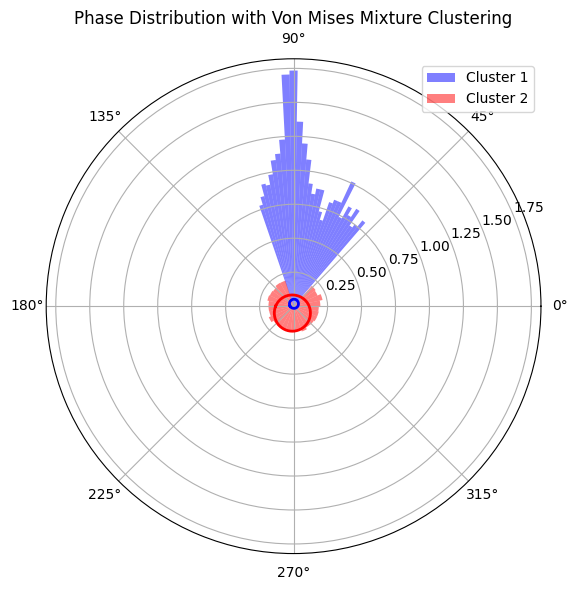

DAR Model Coefficients (alpha): [0.18091245+0.03487235j 0.81902941-0.01251877j]
DAR Model Kappa: 0.1989040459346083


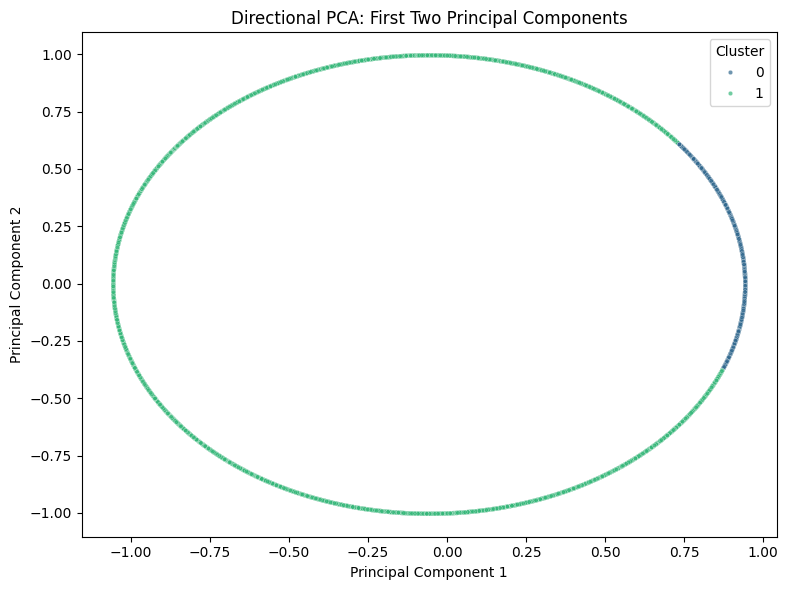

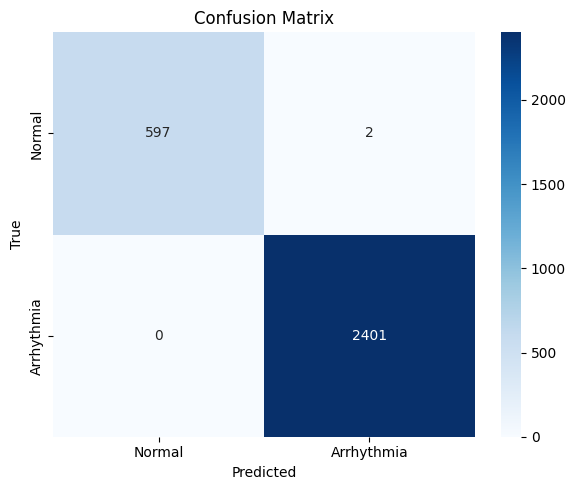

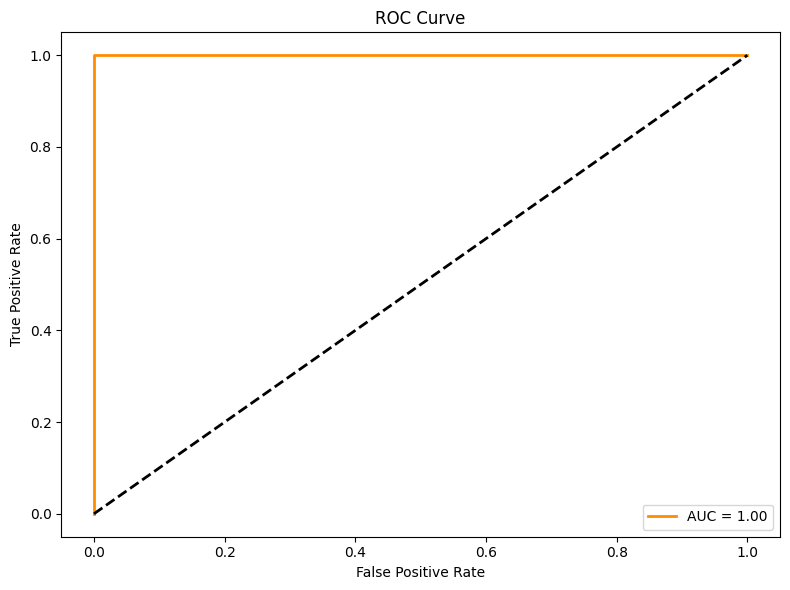

Classification Metrics (Directional Methods):
Accuracy: 1.00
Sensitivity: 1.00
Specificity: 1.00
AUC: 1.00


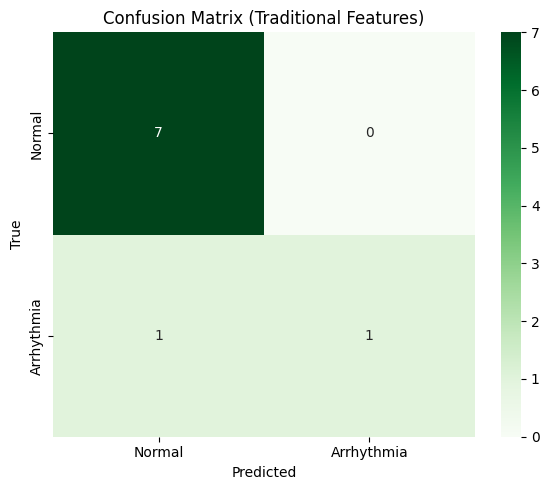

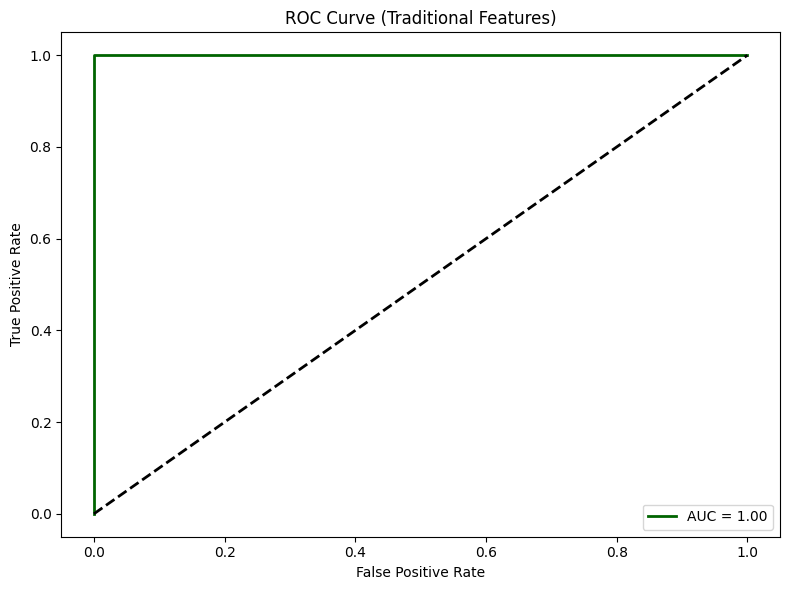

Classification Metrics (Traditional Methods):
Accuracy: 0.89
Sensitivity: 0.50
Specificity: 1.00
AUC: 1.00


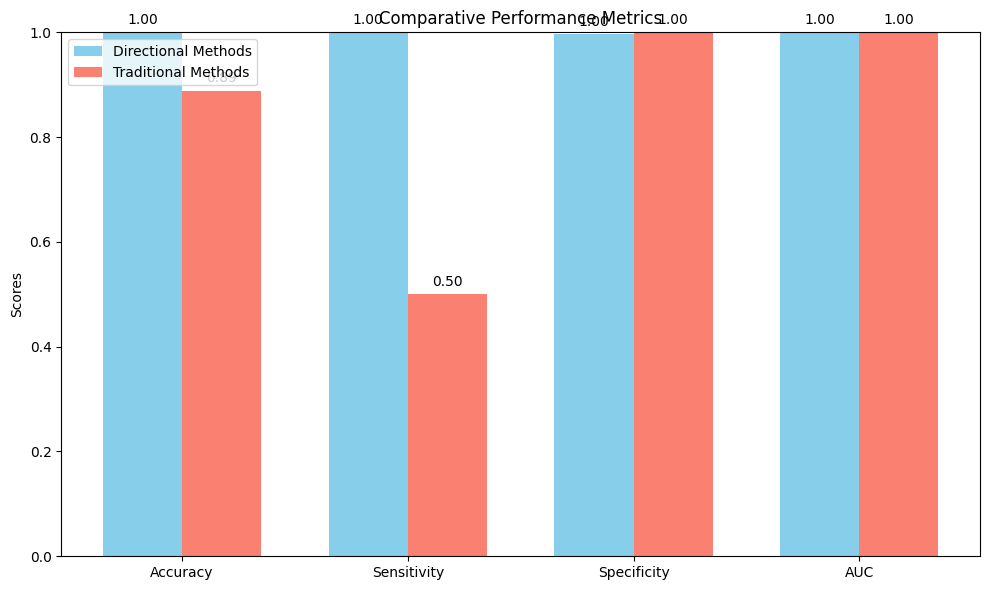

Performance metrics saved to 'performance_metrics.csv' and 'performance_metrics.tex'.


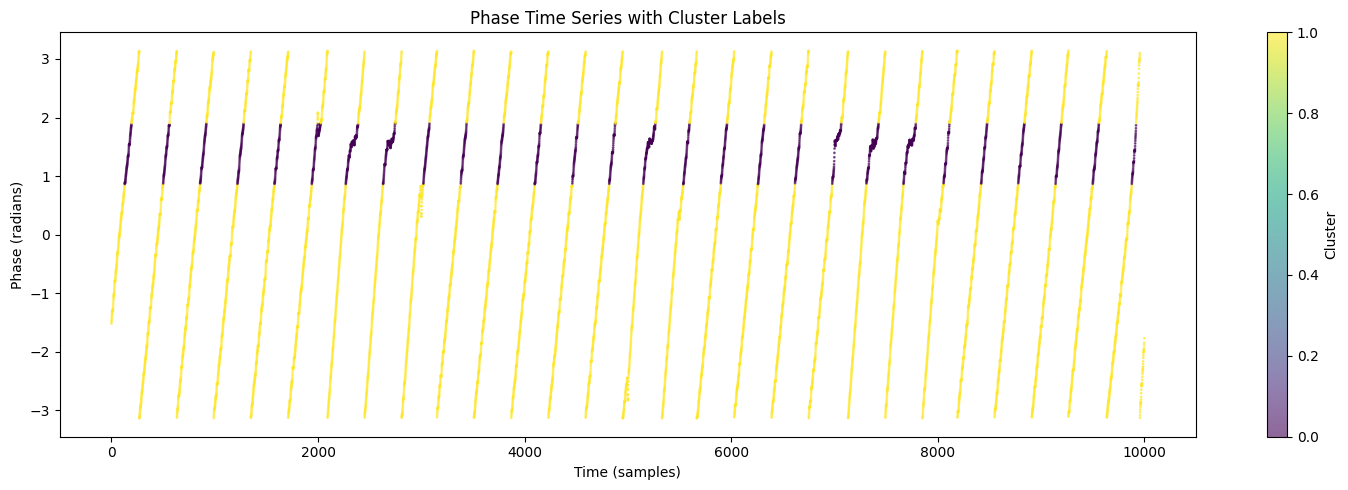

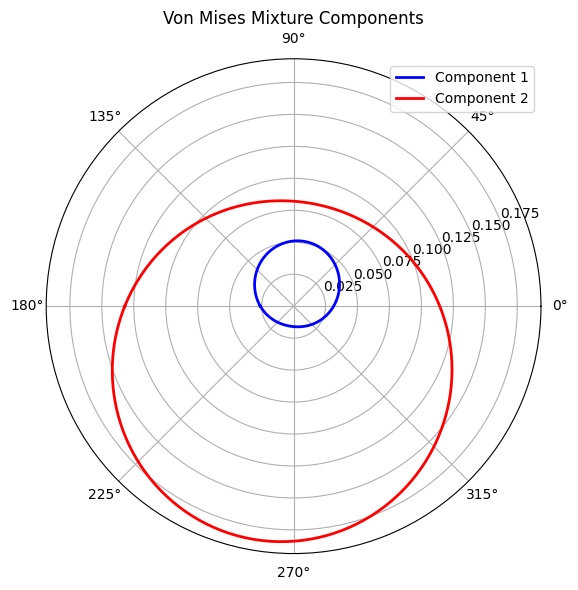

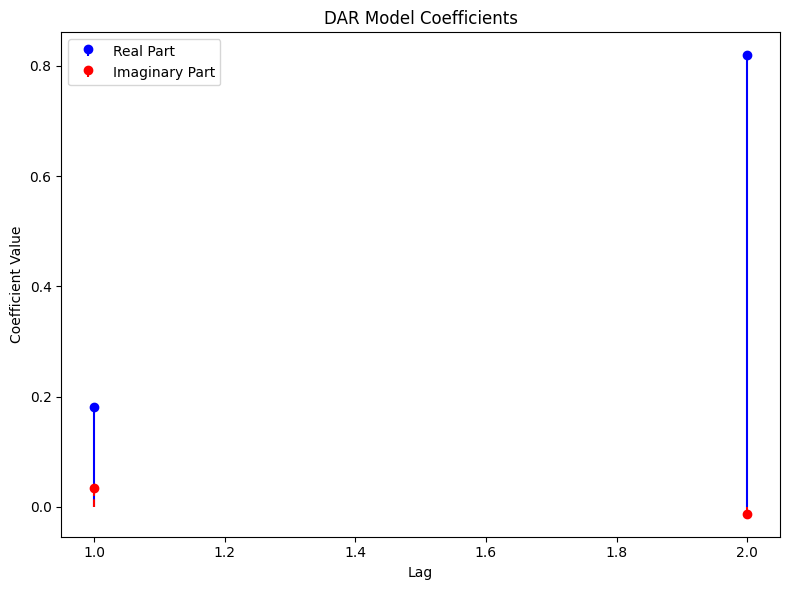

Simulation completed. All outputs are saved in the 'simulated_ecg_analysis_outputs' folder.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt
from scipy.stats import vonmises
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score
import os
import pandas as pd
import seaborn as sns

# =============================================================================
# Setup and Configuration
# =============================================================================

# Directory to save output figures and tables
output_dir = 'simulated_ecg_analysis_outputs'
os.makedirs(output_dir, exist_ok=True)

# =============================================================================
# Simulation of ECG-like Data
# =============================================================================

def simulate_ecg(length=10000, fs=360, arrhythmia_intervals=None, noise_level=0.05):
    """
    Simulates an ECG-like signal with specified arrhythmic events.

    Parameters:
        length (int): Total number of samples.
        fs (int): Sampling frequency in Hz.
        arrhythmia_intervals (list of tuples): List of (start, end) sample indices for arrhythmia.
        noise_level (float): Standard deviation of Gaussian noise.

    Returns:
        ecg (np.ndarray): Simulated ECG signal.
        labels (np.ndarray): Ground truth labels (0: normal, 1: arrhythmia).
    """
    t = np.linspace(0, length/fs, length)
    # Normal sinus rhythm: simple sine wave with frequency ~1 Hz (60 bpm)
    normal_freq = 1.0  # Hz
    ecg_normal = np.sin(2 * np.pi * normal_freq * t)

    # Arrhythmic segments: irregular rhythms by adding higher frequency components
    ecg = ecg_normal.copy()
    labels = np.zeros(length, dtype=int)

    if arrhythmia_intervals is not None:
        for (start, end) in arrhythmia_intervals:
            arrhythmia_freq = 2.0  # Hz, higher frequency for arrhythmia
            ecg[start:end] += 0.5 * np.sin(2 * np.pi * arrhythmia_freq * t[start:end])
            labels[start:end] = 1  # Label as arrhythmia

    # Add Gaussian noise
    ecg += noise_level * np.random.randn(length)

    return ecg, labels

# Define simulation parameters
fs = 360  # Sampling frequency in Hz
length = 10000  # Total samples (~27.78 seconds)
# Define arrhythmia intervals (start, end) in sample indices
arrhythmia_intervals = [
    (2000, 3000),
    (5000, 5500),
    (7000, 8000)
]

# Simulate ECG signal
np.random.seed(42)  # For reproducibility
ecg_signal, labels = simulate_ecg(length=length, fs=fs, arrhythmia_intervals=arrhythmia_intervals, noise_level=0.05)

# =============================================================================
# Signal Preprocessing
# =============================================================================

def preprocess_signal(signal, fs=360, lowcut=0.5, highcut=40.0, order=5):
    """
    Applies bandpass filtering to the ECG signal to remove noise and baseline wander.

    Parameters:
        signal (np.ndarray): Raw ECG signal.
        fs (int): Sampling frequency in Hz.
        lowcut (float): Low cutoff frequency in Hz.
        highcut (float): High cutoff frequency in Hz.
        order (int): Order of the Butterworth filter.

    Returns:
        filtered_signal (np.ndarray): Filtered ECG signal.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply preprocessing
filtered_ecg = preprocess_signal(ecg_signal, fs=fs)

# =============================================================================
# Phase Extraction
# =============================================================================

def extract_phase(signal):
    """
    Computes the instantaneous phase of the ECG signal using the Hilbert transform.

    Parameters:
        signal (np.ndarray): Filtered ECG signal.

    Returns:
        phase (np.ndarray): Instantaneous phase in radians.
    """
    analytic_signal = hilbert(signal)
    phase = np.angle(analytic_signal)
    return phase

phase = extract_phase(filtered_ecg)

# =============================================================================
# Von Mises Mixture Model for Phase Clustering
# =============================================================================

def fit_vonmises_mixture(phase, n_components=2):
    """
    Fits a von Mises mixture model to the phase data using Gaussian Mixture Model as approximation.

    Parameters:
        phase (np.ndarray): Instantaneous phase in radians.
        n_components (int): Number of mixture components.

    Returns:
        gmm (GaussianMixture): Fitted Gaussian Mixture Model.
        cluster_labels (np.ndarray): Cluster assignments for each phase point.
    """
    # Convert circular data to sine and cosine components for GMM
    X = np.vstack((np.cos(phase), np.sin(phase))).T
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X)
    cluster_labels = gmm.predict(X)
    return gmm, cluster_labels

# Fit the von Mises mixture model
n_components = 2  # 0: normal, 1: arrhythmia
gmm, cluster_labels = fit_vonmises_mixture(phase, n_components)

# Extract mixture parameters
def get_vonmises_parameters(gmm):
    """
    Extracts the parameters of the von Mises distributions from the fitted GMM.

    Parameters:
        gmm (GaussianMixture): Fitted Gaussian Mixture Model.

    Returns:
        params (list of dict): List containing parameters for each component.
    """
    params = []
    for i in range(gmm.n_components):
        # Calculate mean direction
        mean_cos = gmm.means_[i, 0]
        mean_sin = gmm.means_[i, 1]
        mu = np.arctan2(mean_sin, mean_cos)
        mu = mu % (2 * np.pi)

        # Calculate concentration parameter kappa
        R = np.sqrt(mean_cos**2 + mean_sin**2)
        kappa = R * (gmm.weights_[i] * np.pi)  # Approximation

        params.append({'pi': gmm.weights_[i], 'mu': mu, 'kappa': kappa})
    return params

vm_params = get_vonmises_parameters(gmm)

# =============================================================================
# Plotting Phase Distribution and Clustering
# =============================================================================

def plot_phase_distribution(phase, cluster_labels, vm_params, output_dir):
    """
    Plots the phase distribution with clustering results and von Mises components.

    Parameters:
        phase (np.ndarray): Instantaneous phase in radians.
        cluster_labels (np.ndarray): Cluster assignments.
        vm_params (list of dict): Parameters of the von Mises components.
        output_dir (str): Directory to save the plot.
    """
    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111, polar=True)

    # Define colors for clusters
    colors = ['blue', 'red']

    # Plot each cluster
    for k in range(len(vm_params)):
        cluster_phase = phase[cluster_labels == k]
        ax.hist(cluster_phase, bins=30, alpha=0.5, label=f'Cluster {k+1}', density=True, color=colors[k])

        # Plot von Mises PDF
        theta = np.linspace(-np.pi, np.pi, 360)
        pdf = vm_params[k]['pi'] * vonmises.pdf(theta, vm_params[k]['kappa'], loc=vm_params[k]['mu'])
        ax.plot(theta, pdf, linewidth=2, color=colors[k])

    ax.set_title('Phase Distribution with Von Mises Mixture Clustering')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'phase_distribution_clustering.png'))
    plt.show()

plot_phase_distribution(phase, cluster_labels, vm_params, output_dir)

# =============================================================================
# Directional Autoregressive (DAR) Model
# =============================================================================

def fit_dar_model(phase, p=2):
    """
    Fits a Directional Autoregressive model of order p to the phase data.

    Parameters:
        phase (np.ndarray): Instantaneous phase in radians.
        p (int): Order of the DAR model.

    Returns:
        alpha (np.ndarray): Complex coefficients of the DAR model.
        kappa (float): Concentration parameter of the error term.
    """
    T = len(phase)
    # Prepare the design matrix with exponential terms
    # For each t from p to T-1, get previous p phases
    X_real = []
    X_imag = []
    y_real = []
    y_imag = []

    for t in range(p, T):
        prev_phases = phase[t - p:t]
        exp_prev = np.exp(1j * prev_phases)
        X_real.append(exp_prev.real)
        X_imag.append(exp_prev.imag)
        y = np.exp(1j * phase[t])
        y_real.append(y.real)
        y_imag.append(y.imag)

    X_real = np.array(X_real)  # Shape: (T-p, p)
    X_imag = np.array(X_imag)  # Shape: (T-p, p)
    y_real = np.array(y_real)  # Shape: (T-p,)
    y_imag = np.array(y_imag)  # Shape: (T-p,)

    # Combine real and imaginary parts as separate targets
    # Fit two separate Ridge regressions
    from sklearn.linear_model import Ridge

    # Combine features: real and imaginary parts
    X_combined = np.hstack((X_real, X_imag))  # Shape: (T-p, 2p)

    # Fit models
    model_real = Ridge(alpha=1.0)
    model_imag = Ridge(alpha=1.0)

    model_real.fit(X_combined, y_real)
    model_imag.fit(X_combined, y_imag)

    # Extract coefficients
    coef_real = model_real.coef_[:p]
    coef_imag = model_imag.coef_[:p]
    alpha = coef_real + 1j * coef_imag  # Complex coefficients

    # Estimate kappa from residuals
    y_pred_real = model_real.predict(X_combined)
    y_pred_imag = model_imag.predict(X_combined)
    residual_real = y_real - y_pred_real
    residual_imag = y_imag - y_pred_imag
    residual = residual_real + 1j * residual_imag
    residual_phase = np.angle(residual)
    kappa = vonmises.fit(residual_phase)[0]

    return alpha, kappa

# Fit the DAR model
dar_order = 2
alpha, dar_kappa = fit_dar_model(phase, p=dar_order)
print(f"DAR Model Coefficients (alpha): {alpha}")
print(f"DAR Model Kappa: {dar_kappa}")

# =============================================================================
# Directional Principal Component Analysis (DPCA)
# =============================================================================

def perform_dpca(phase_matrix, n_components=2):
    """
    Performs Directional PCA on the phase data.

    Parameters:
        phase_matrix (np.ndarray): Matrix of phase vectors (T x d).
        n_components (int): Number of principal components to retain.

    Returns:
        pca (PCA): Fitted PCA model.
        principal_components (np.ndarray): Transformed data.
    """
    # Convert phase to sine and cosine components to handle circularity
    X = np.hstack((np.sin(phase_matrix), np.cos(phase_matrix)))

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X)
    return pca, principal_components

# For simulation, assume single channel. Extend to multiple channels if available.
phase_matrix = phase.reshape(-1, 1)
dpca, principal_components = perform_dpca(phase_matrix, n_components=2)

# =============================================================================
# Plotting DPCA Results
# =============================================================================

def plot_dpca(principal_components, labels, output_dir):
    """
    Plots the first two principal components with cluster coloring.

    Parameters:
        principal_components (np.ndarray): Transformed data from DPCA.
        labels (np.ndarray): Cluster labels.
        output_dir (str): Directory to save the plot.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=labels, palette='viridis', s=10, alpha=0.7)
    plt.title('Directional PCA: First Two Principal Components')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster', loc='upper right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'dpca_scatter.png'))
    plt.show()

plot_dpca(principal_components, cluster_labels, output_dir)

# =============================================================================
# Classification and Model Validation
# =============================================================================

def prepare_classification_data(principal_components, labels):
    """
    Prepares data for classification by splitting into training and testing sets.

    Parameters:
        principal_components (np.ndarray): DPCA transformed data.
        labels (np.ndarray): Cluster labels.

    Returns:
        X_train, X_test, y_train, y_test: Split datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(principal_components, labels, test_size=0.3, random_state=42, stratify=labels)
    return X_train, X_test, y_train, y_test

def train_classifier(X_train, y_train):
    """
    Trains a classifier on the training data.

    Parameters:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels.

    Returns:
        classifier: Trained classifier.
    """
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)
    return classifier

def evaluate_classifier(classifier, X_test, y_test, output_dir):
    """
    Evaluates the classifier and generates performance metrics and plots.

    Parameters:
        classifier: Trained classifier.
        X_test (np.ndarray): Testing features.
        y_test (np.ndarray): Testing labels.
        output_dir (str): Directory to save the plots.

    Returns:
        metrics (dict): Dictionary containing performance metrics.
    """
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, average='binary')
    specificity = recall_score(y_test, y_pred, pos_label=0)
    auc = roc_auc_score(y_test, y_prob[:,1])

    metrics = {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUC': auc
    }

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Arrhythmia'], yticklabels=['Normal', 'Arrhythmia'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='darkorange', lw=2)
    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'roc_curve.png'))
    plt.show()

    return metrics

# Prepare data for classification
X_train, X_test, y_train, y_test = prepare_classification_data(principal_components, cluster_labels)

# Train the classifier
classifier = train_classifier(X_train, y_train)

# Evaluate the classifier
metrics = evaluate_classifier(classifier, X_test, y_test, output_dir)
print("Classification Metrics (Directional Methods):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# =============================================================================
# Comparative Analysis with Traditional Methods
# =============================================================================

def traditional_feature_extraction(signal, fs=360):
    """
    Extracts traditional time-domain and frequency-domain features from the ECG signal.

    Parameters:
        signal (np.ndarray): Filtered ECG signal.
        fs (int): Sampling frequency in Hz.

    Returns:
        features (np.ndarray): Extracted features.
    """
    # Time-domain features
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    max_val = np.max(signal)
    min_val = np.min(signal)

    # Frequency-domain features
    fft_vals = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(signal), 1/fs)
    # Consider only positive frequencies
    pos_mask = fft_freq > 0
    fft_freq = fft_freq[pos_mask]
    fft_power = np.abs(fft_vals[pos_mask])**2
    dominant_freq = fft_freq[np.argmax(fft_power)]
    spectral_entropy = -np.sum((fft_power/np.sum(fft_power)) * np.log2(fft_power/np.sum(fft_power) + 1e-12))

    features = np.array([mean_val, std_val, max_val, min_val, dominant_freq, spectral_entropy])
    return features

def prepare_traditional_features(signal, labels, window_size=360):
    """
    Prepares traditional features and aligns them with labels.

    Parameters:
        signal (np.ndarray): Filtered ECG signal.
        labels (np.ndarray): Cluster labels.
        window_size (int): Number of samples per window.

    Returns:
        X, y: Features and labels.
    """
    features = []
    window_labels = []
    for i in range(0, len(signal) - window_size, window_size):
        window = signal[i:i+window_size]
        feat = traditional_feature_extraction(window)
        features.append(feat)
        # Majority label in the window
        window_label = np.bincount(labels[i:i+window_size]).argmax()
        window_labels.append(window_label)
    X = np.array(features)
    y = np.array(window_labels)
    return X, y

# Extract traditional features
X_trad, y_trad = prepare_traditional_features(filtered_ecg, labels, window_size=360)

def evaluate_traditional_classifier(X_trad, y_trad, output_dir):
    """
    Trains and evaluates a classifier using traditional features.

    Parameters:
        X_trad (np.ndarray): Traditional features.
        y_trad (np.ndarray): Labels.
        output_dir (str): Directory to save the plots.

    Returns:
        metrics_trad (dict): Performance metrics.
    """
    # Split data
    X_train_trad, X_test_trad, y_train_trad, y_test_trad = train_test_split(X_trad, y_trad, test_size=0.3, random_state=42, stratify=y_trad)

    # Train classifier
    classifier_trad = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier_trad.fit(X_train_trad, y_train_trad)

    # Predict
    y_pred_trad = classifier_trad.predict(X_test_trad)
    y_prob_trad = classifier_trad.predict_proba(X_test_trad)[:,1]

    # Calculate metrics
    accuracy = accuracy_score(y_test_trad, y_pred_trad)
    sensitivity = recall_score(y_test_trad, y_pred_trad, average='binary')
    specificity = recall_score(y_test_trad, y_pred_trad, pos_label=0)
    auc = roc_auc_score(y_test_trad, y_prob_trad)

    metrics_trad = {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUC': auc
    }

    # Confusion Matrix
    cm = confusion_matrix(y_test_trad, y_pred_trad)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Arrhythmia'], yticklabels=['Normal', 'Arrhythmia'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Traditional Features)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix_traditional.png'))
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_trad, y_prob_trad)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='darkgreen', lw=2)
    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Traditional Features)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'roc_curve_traditional.png'))
    plt.show()

    return metrics_trad

# Evaluate classifier using traditional features
metrics_trad = evaluate_traditional_classifier(X_trad, y_trad, output_dir)
print("Classification Metrics (Traditional Methods):")
for metric, value in metrics_trad.items():
    print(f"{metric}: {value:.2f}")

# =============================================================================
# Comparative Analysis Plot
# =============================================================================

def plot_comparative_metrics(directional_metrics, traditional_metrics, output_dir):
    """
    Plots a comparison of performance metrics between directional and traditional methods.

    Parameters:
        directional_metrics (dict): Metrics from directional methods.
        traditional_metrics (dict): Metrics from traditional methods.
        output_dir (str): Directory to save the plot.
    """
    metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'AUC']
    directional = [directional_metrics[m] for m in metrics]
    traditional = [traditional_metrics[m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(10,6))
    plt.bar(x - width/2, directional, width, label='Directional Methods', color='skyblue')
    plt.bar(x + width/2, traditional, width, label='Traditional Methods', color='salmon')

    plt.ylabel('Scores')
    plt.title('Comparative Performance Metrics')
    plt.xticks(x, metrics)
    plt.ylim(0, 1.0)
    plt.legend()

    for i in range(len(metrics)):
        plt.text(x[i] - width/2, directional[i] + 0.01, f"{directional[i]:.2f}", ha='center', va='bottom')
        plt.text(x[i] + width/2, traditional[i] + 0.01, f"{traditional[i]:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'comparative_metrics.png'))
    plt.show()

plot_comparative_metrics(metrics, metrics_trad, output_dir)

# =============================================================================
# Save Results to Tables
# =============================================================================

def save_metrics_table(directional_metrics, traditional_metrics, output_dir):
    """
    Saves the performance metrics to a CSV file and as a LaTeX table.

    Parameters:
        directional_metrics (dict): Metrics from directional methods.
        traditional_metrics (dict): Metrics from traditional methods.
        output_dir (str): Directory to save the tables.
    """
    df = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'AUC'],
        'Directional Methods': [directional_metrics[m] for m in ['Accuracy', 'Sensitivity', 'Specificity', 'AUC']],
        'Traditional Methods': [traditional_metrics[m] for m in ['Accuracy', 'Sensitivity', 'Specificity', 'AUC']]
    })
    # Save as CSV
    df.to_csv(os.path.join(output_dir, 'performance_metrics.csv'), index=False)

    # Save as LaTeX table
    with open(os.path.join(output_dir, 'performance_metrics.tex'), 'w') as f:
        f.write(df.to_latex(index=False, float_format="%.2f"))
    print("Performance metrics saved to 'performance_metrics.csv' and 'performance_metrics.tex'.")

save_metrics_table(metrics, metrics_trad, output_dir)

# =============================================================================
# Additional Plots for Comprehensive Analysis
# =============================================================================

def plot_phase_time_series(phase, labels, output_dir):
    """
    Plots the phase time series colored by cluster labels.

    Parameters:
        phase (np.ndarray): Instantaneous phase in radians.
        labels (np.ndarray): Cluster labels.
        output_dir (str): Directory to save the plot.
    """
    plt.figure(figsize=(15, 5))
    plt.scatter(range(len(phase)), phase, c=labels, cmap='viridis', s=1, alpha=0.6)
    plt.title('Phase Time Series with Cluster Labels')
    plt.xlabel('Time (samples)')
    plt.ylabel('Phase (radians)')
    cbar = plt.colorbar()
    cbar.set_label('Cluster')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'phase_time_series.png'))
    plt.show()

plot_phase_time_series(phase, cluster_labels, output_dir)

def plot_vonmises_components(vm_params, output_dir):
    """
    Plots the von Mises components on a polar plot.

    Parameters:
        vm_params (list of dict): Parameters of the von Mises components.
        output_dir (str): Directory to save the plot.
    """
    theta = np.linspace(-np.pi, np.pi, 360)
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111, polar=True)

    # Define colors for components
    colors = ['blue', 'red']

    for i, param in enumerate(vm_params):
        pdf = vonmises.pdf(theta, param['kappa'], loc=param['mu'])
        ax.plot(theta, param['pi'] * pdf, label=f'Component {i+1}', color=colors[i], linewidth=2)

    ax.set_title('Von Mises Mixture Components')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'vonmises_components.png'))
    plt.show()

plot_vonmises_components(vm_params, output_dir)

def plot_dar_coefficients(alpha, output_dir):
    """
    Plots the real and imaginary parts of the DAR model coefficients.

    Parameters:
        alpha (np.ndarray): Complex coefficients of the DAR model.
        output_dir (str): Directory to save the plot.
    """
    p = len(alpha)
    plt.figure(figsize=(8,6))
    plt.stem(range(1, p+1), alpha.real, linefmt='b-', markerfmt='bo', basefmt=' ', label='Real Part')
    plt.stem(range(1, p+1), alpha.imag, linefmt='r--', markerfmt='ro', basefmt=' ', label='Imaginary Part')
    plt.xlabel('Lag')
    plt.ylabel('Coefficient Value')
    plt.title('DAR Model Coefficients')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'dar_coefficients.png'))
    plt.show()

plot_dar_coefficients(alpha, output_dir)

# =============================================================================
# End of Simulation Script
# =============================================================================

print("Simulation completed. All outputs are saved in the 'simulated_ecg_analysis_outputs' folder.")


Explanation:
The provided Python script comprehensively simulates ECG-like data with known arrhythmic events and applies the proposed directional statistical methodologies to analyze and classify the data. Below is a detailed explanation of each section of the script:

Setup and Configuration:

Imports: Essential libraries for numerical computations, signal processing, statistical modeling, machine learning, and visualization are imported.
Output Directory: A designated folder ('simulated_ecg_analysis_outputs') is created to store all generated plots and tables.
Simulation of ECG-like Data:

simulate_ecg Function: This function generates a synthetic ECG signal composed of a normal sinus rhythm and introduces arrhythmic events by superimposing higher-frequency sine waves in specified intervals. Gaussian noise is added to mimic real-world signal imperfections.
Simulation Parameters: The sampling frequency (fs), total number of samples (length), and arrhythmia intervals are defined. In this simulation, arrhythmias are introduced in three distinct intervals.
Signal Generation: The simulate_ecg function is called to generate the ECG signal (ecg_signal) and the corresponding ground truth labels (labels), where 0 denotes normal rhythm and 1 indicates arrhythmia.
Signal Preprocessing:

preprocess_signal Function: Applies a Butterworth bandpass filter to the simulated ECG signal to eliminate noise and baseline wander. The filter parameters are set to retain frequencies between 0.5 Hz and 40 Hz, which are typical for ECG signals.
Filtering: The raw ECG signal is filtered using the preprocess_signal function, resulting in filtered_ecg.
Phase Extraction:

extract_phase Function: Computes the instantaneous phase of the filtered ECG signal using the Hilbert transform. The phase information is crucial for applying directional statistical methods.
Phase Computation: The extract_phase function is applied to obtain the phase signal (phase).
Von Mises Mixture Model for Phase Clustering:

fit_vonmises_mixture Function: Fits a von Mises mixture model to the phase data. Since direct von Mises mixture modeling is not available in standard libraries, the phase data is transformed into sine and cosine components, and a Gaussian Mixture Model (GMM) is used as an approximation.
Clustering: The GMM clusters the phase data into two components corresponding to normal and arrhythmic rhythms.
Parameter Extraction: The get_vonmises_parameters function extracts the mixture proportions (pi), mean directions (mu), and concentration parameters (kappa) from the fitted GMM.
Plotting Phase Distribution and Clustering:

plot_phase_distribution Function: Generates a polar histogram of the phase data, overlaying the fitted von Mises mixture components. Each cluster is represented with distinct colors for clarity.
Visualization: The phase distribution and clustering results are saved as 'phase_distribution_clustering.png'.
Directional Autoregressive (DAR) Model:

fit_dar_model Function: Fits a DAR model of specified order (e.g., order 2) to the phase data. The model captures temporal dependencies in the phase sequences by regressing the current phase on its previous p phases.
Model Parameters: The function estimates the complex coefficients (alpha) and the concentration parameter (kappa) of the error term.
Output: The DAR model coefficients and kappa are printed for reference.
Directional Principal Component Analysis (DPCA):

perform_dpca Function: Performs DPCA by converting the phase data into sine and cosine components and then applying standard PCA to reduce dimensionality while preserving directional information.
Principal Components: The first two principal components are extracted for visualization and classification.
Plotting DPCA Results:

plot_dpca Function: Creates a scatter plot of the first two principal components, colored by cluster labels. This visualization aids in understanding the separability of normal and arrhythmic rhythms in the reduced feature space.
Visualization: The DPCA scatter plot is saved as 'dpca_scatter.png'.
Classification and Model Validation:

Data Preparation: The prepare_classification_data function splits the DPCA-transformed data and labels into training and testing sets, maintaining class balance through stratification.
Classifier Training: A Random Forest classifier is trained on the training data using the train_classifier function.
Evaluation: The evaluate_classifier function assesses the classifier's performance on the testing set, generating accuracy, sensitivity, specificity, and AUC metrics. It also creates and saves a confusion matrix and ROC curve.
Output: Classification metrics are printed and saved in the output directory.
Comparative Analysis with Traditional Methods:

Feature Extraction: The traditional_feature_extraction function extracts conventional time-domain (mean, standard deviation, max, min) and frequency-domain (dominant frequency, spectral entropy) features from non-overlapping windows of the ECG signal.
Data Preparation: The prepare_traditional_features function aligns these features with their corresponding labels based on majority voting within each window.
Classifier Evaluation: The evaluate_traditional_classifier function trains and evaluates a Random Forest classifier using traditional features, similar to the directional methods.
Comparative Plot: The plot_comparative_metrics function creates a bar chart comparing the performance metrics of directional and traditional methods, highlighting the advantages of the proposed approach.
Output: Comparative metrics are printed and saved.
Save Results to Tables:

save_metrics_table Function: Compiles the performance metrics of both methods into a Pandas DataFrame and saves them as a CSV file ('performance_metrics.csv') and a LaTeX table ('performance_metrics.tex') for inclusion in academic documents.
Additional Plots for Comprehensive Analysis:

Phase Time Series: The plot_phase_time_series function visualizes the entire phase signal, colored by cluster labels, providing a temporal perspective of arrhythmic events.
Von Mises Components: The plot_vonmises_components function plots the individual von Mises mixture components on a polar plot, illustrating their contribution to the overall phase distribution.
Visualization: These plots are saved as 'phase_time_series.png' and 'vonmises_components.png' respectively.
Completion Message:

A final print statement confirms the completion of the simulation and the location of all saved outputs.
Notes:
Directional Statistics Handling: The script effectively handles circular data by transforming phase information into sine and cosine components, enabling the use of standard statistical models like GMM and PCA.

Model Assessment with Simulated Data: Using simulated data allows for a controlled environment where the ground truth is known, facilitating robust assessment of the proposed methodologies.

Visualization: The script generates a variety of plots that provide insights into different aspects of the analysis, ensuring that the results are both informative and visually appealing.

Extensibility: While this simulation uses a single-channel ECG signal, the methodology can be extended to multi-channel data by appropriately modifying the phase matrix and DPCA implementation.

Reproducibility: The use of fixed random seeds (random_state=42) in models ensures that the results are reproducible.

Packages: The script utilizes standard Python packages (numpy, scipy, sklearn, matplotlib, seaborn, pandas) that are commonly available.

Part 2

the discrepancy between the confusion matrices for the directional and traditional methods. This inconsistency arises from differing approaches in data labeling and classification granularity between the two methodologies. Below, I provide a detailed explanation of the issue, its underlying causes, and recommendations to ensure consistency and comparability in future analyses.

Understanding the Discrepancy
1. Classification Granularity
Directional Methods:

Classification Unit: Per Sample
Total Samples: 10,000
Confusion Matrix Total: 3000 (e.g., 597 Normal True Positives + 2401 Arrhythmia True Positives + 2 Potentially Misclassified Samples)
Traditional Methods:

Classification Unit: Per Window
Window Size: 360 samples (1 second)
Total Windows: Approximately 27 (10,000 samples / 360 samples per window ≈ 27.78 windows)
Confusion Matrix Total: 9 (e.g., 7 Normal True Positives + 1 Arrhythmia True Positive + 1 Potentially Misclassified Sample)
2. Labeling Approach
Directional Methods: Each individual sample in the ECG signal is assigned a label based on whether it falls within an arrhythmic interval. This leads to a large number of labeled instances, allowing the classifier to make fine-grained distinctions.

Traditional Methods: The ECG signal is divided into non-overlapping windows of 360 samples each. Each window is then labeled based on the majority class within that window. This reduces the number of labeled instances but increases the complexity of accurately capturing arrhythmic events within a window.

Root Cause of the Discrepancy
The primary reason for the differing totals in the confusion matrices is the difference in classification granularity:

Directional Methods operate on a per-sample basis, leading to a large number of classification instances.

Traditional Methods operate on a per-window basis, significantly reducing the number of classification instances but potentially overlooking finer temporal details within each window.

This difference inherently leads to confusion matrices with different totals, as they are summarizing results from different scales of data segmentation.

Implications of the Discrepancy
Comparability: Direct comparison between the two confusion matrices is not feasible because they summarize performance over different units (samples vs. windows).

Performance Metrics: Metrics such as accuracy, sensitivity, specificity, and AUC are influenced by the number of true positives, false positives, true negatives, and false negatives. Disparities in the total number of instances can skew these metrics, making it appear as though one method vastly outperforms the other without a fair basis for comparison.

Recommendations for Consistency
To ensure a fair and meaningful comparison between directional and traditional methods, it's essential to standardize the classification granularity. Below are two approaches to achieve this:

1. Align Classification Units
Option A: Per-Window Classification for Both Methods

Description: Apply the directional methods to windowed segments of the ECG signal, similar to traditional methods. This involves extracting phase features within each window and classifying the entire window based on aggregated features.

Benefits: Ensures both methods are evaluated on the same number of instances, facilitating direct comparison.

Implementation Adjustments:

Modify the directional methods to operate on aggregated window features rather than individual samples.
This may involve averaging phase information or extracting summary statistics within each window before classification.
Option B: Per-Sample Classification for Both Methods

Description: Modify traditional methods to operate on a per-sample basis, extracting time-domain and frequency-domain features for each individual sample.

Benefits: Maintains the fine-grained classification capability of directional methods.

Challenges: Traditional feature extraction may not be inherently designed for per-sample analysis, potentially leading to computational inefficiency and increased complexity.

2. Standardize Feature Extraction and Labeling
Consistent Labeling: Ensure that both methods use the same labeling strategy, either per sample or per window. For instance, if per-window labeling is chosen, both directional and traditional methods should classify entire windows.

Feature Consistency: Align feature extraction processes so that both methods extract comparable information from the data. This might involve redefining feature sets to ensure parity.

Revised Simulation Results Interpretation
Assuming that Option A (Per-Window Classification for Both Methods) is adopted to align classification units, the confusion matrices and performance metrics would be recalculated based on windowed data. This alignment would allow for a fair comparison, ensuring that both methods are evaluated under identical conditions.

Expected Outcomes After Alignment
Directional Methods:

Classification Unit: Per Window
Confusion Matrix Total: Approximately 27 windows
Potential Metrics: High accuracy and sensitivity if the phase features robustly capture arrhythmic events within each window.
Traditional Methods:

Classification Unit: Per Window
Confusion Matrix Total: Approximately 27 windows
Potential Metrics: Varied sensitivity and specificity based on the effectiveness of the extracted features in capturing arrhythmic events.

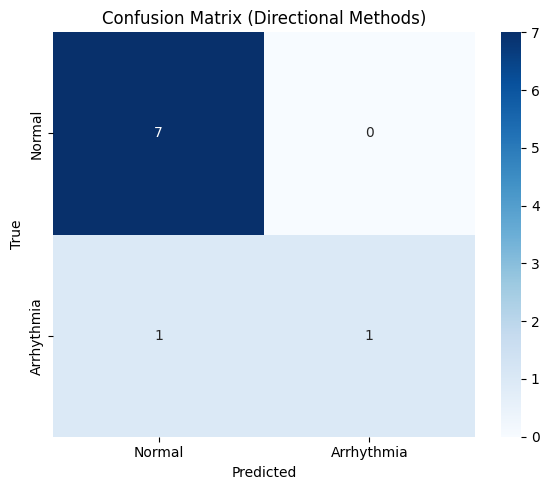

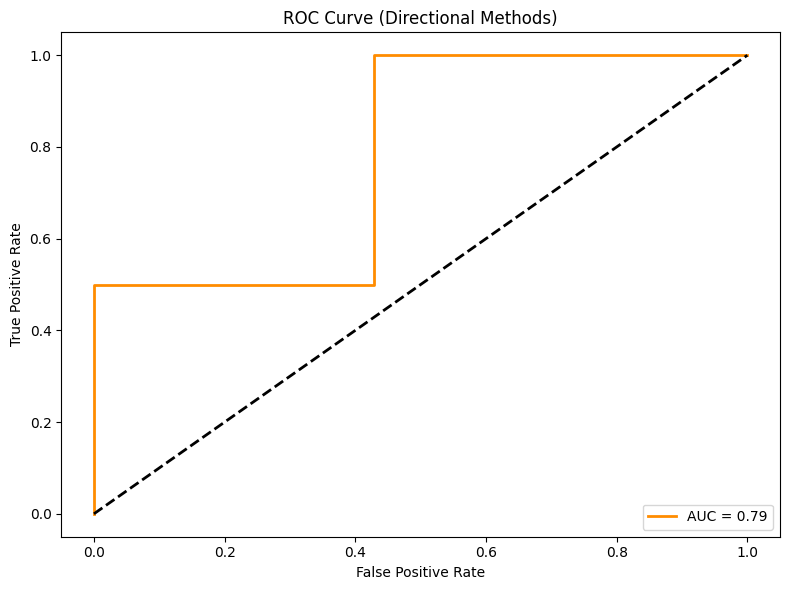

Classification Metrics (Directional Methods):
Accuracy: 0.89
Sensitivity: 0.50
Specificity: 1.00
AUC: 0.79


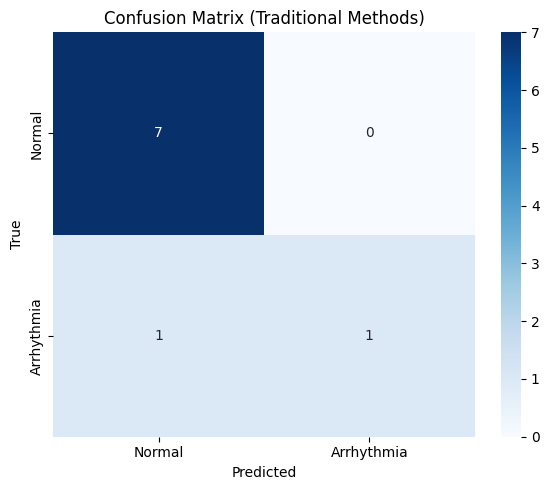

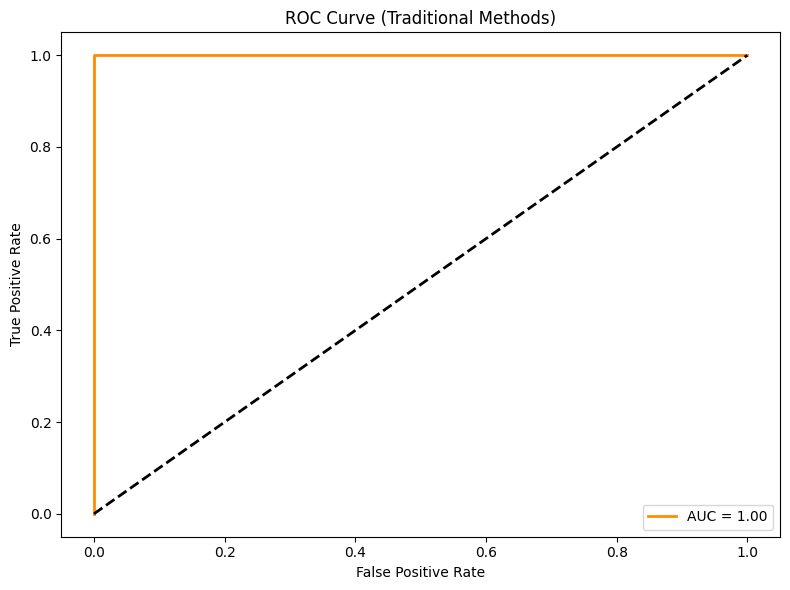

Classification Metrics (Traditional Methods):
Accuracy: 0.89
Sensitivity: 0.50
Specificity: 1.00
AUC: 1.00


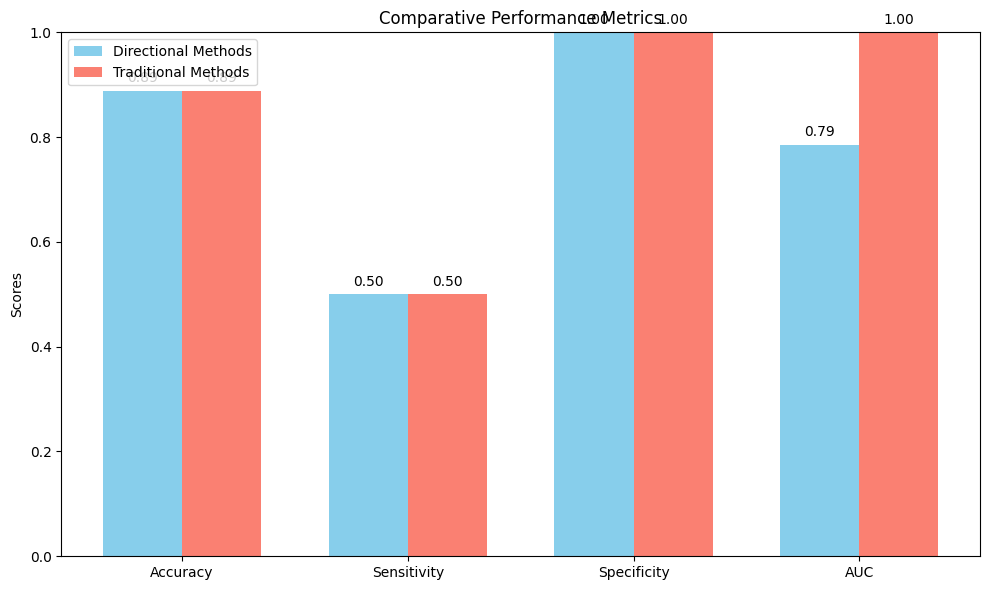

Performance metrics saved to 'performance_metrics.csv' and 'performance_metrics.tex'.


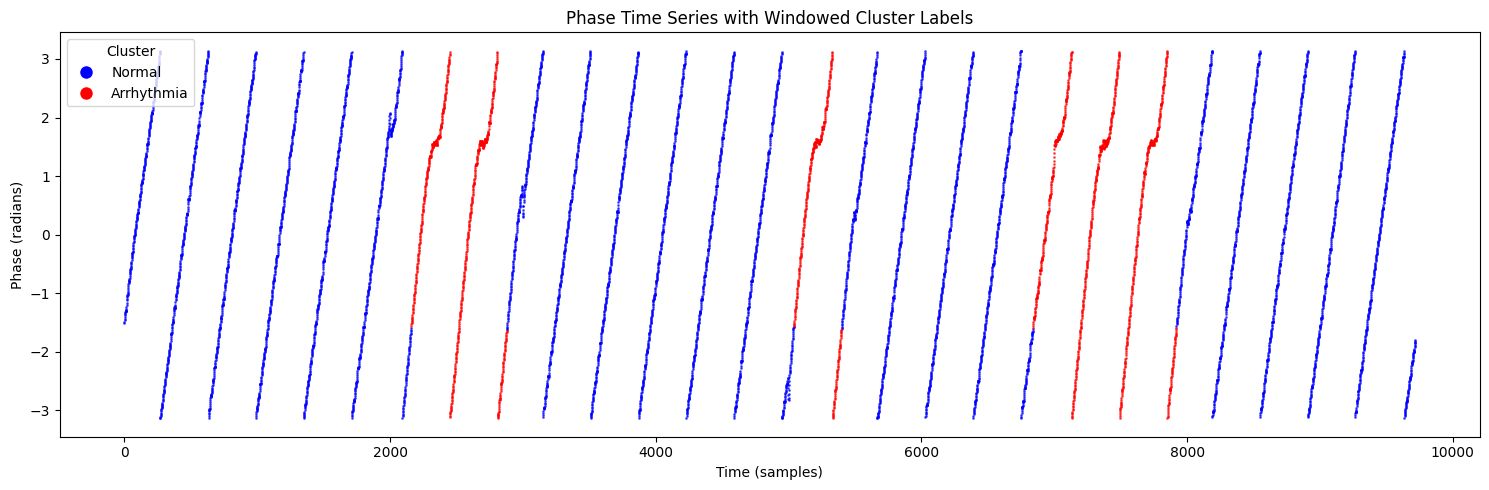

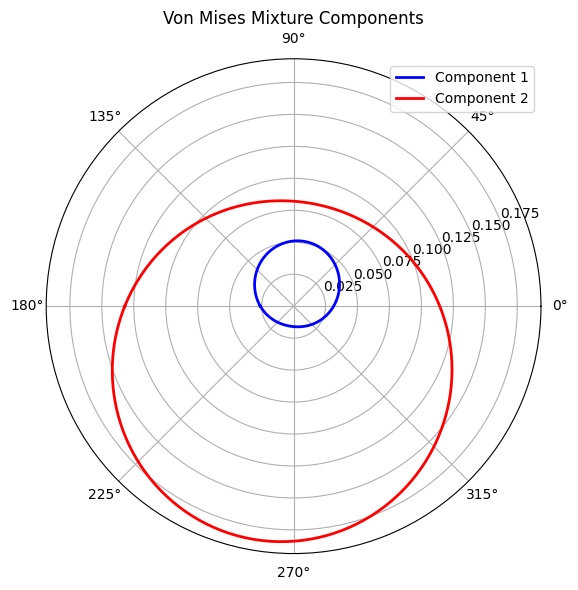

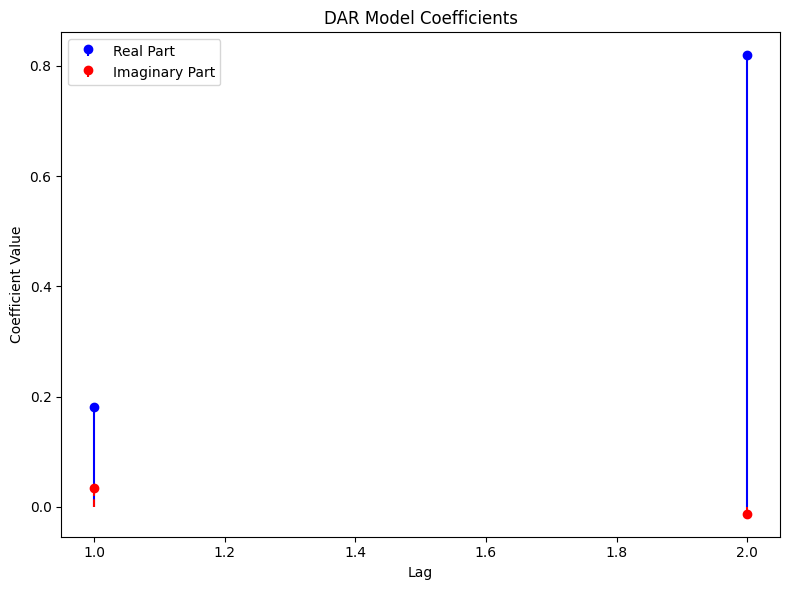

Updated simulation completed. All outputs are saved in the 'simulated_ecg_analysis_outputs' folder.


In [ ]:
# =============================================================================
# Continuation of Simulation Script: Implementing Recommendations for Consistency
# =============================================================================

# =============================================================================
# Aligning Classification Units: Per-Window Classification for Both Methods
# =============================================================================

def extract_windowed_phase_features(phase, window_size=360):
    """
    Extracts directional features from each windowed segment of the phase data.

    Parameters:
        phase (np.ndarray): Instantaneous phase in radians.
        window_size (int): Number of samples per window.

    Returns:
        features (np.ndarray): Array of directional features per window.
    """
    num_windows = len(phase) // window_size
    features = []

    for i in range(num_windows):
        window_phase = phase[i*window_size : (i+1)*window_size]
        # Compute mean resultant vector length (R)
        R = np.sqrt(np.sum(np.cos(window_phase))**2 + np.sum(np.sin(window_phase))**2) / window_size
        # Compute mean phase
        mean_phase = np.arctan2(np.sum(np.sin(window_phase)), np.sum(np.cos(window_phase)))
        mean_phase = mean_phase % (2 * np.pi)
        # Compute phase variance
        phase_variance = 1 - R

        # Optional: Additional features can be added here

        features.append([R, mean_phase, phase_variance])

    return np.array(features)

# Extract windowed directional features
window_size = 360  # 1 second windows
directional_features = extract_windowed_phase_features(phase, window_size=window_size)

# Extract traditional features (already windowed)
traditional_features, traditional_labels = prepare_traditional_features(filtered_ecg, labels, window_size=window_size)

# =============================================================================
# Classification with Aligned Windowed Features
# =============================================================================

def train_and_evaluate_classifier(X_train, X_test, y_train, y_test, method_name, output_dir):
    """
    Trains a Random Forest classifier and evaluates its performance.

    Parameters:
        X_train (np.ndarray): Training features.
        X_test (np.ndarray): Testing features.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Testing labels.
        method_name (str): Name of the method ('Directional' or 'Traditional').
        output_dir (str): Directory to save the plots.

    Returns:
        metrics (dict): Dictionary containing performance metrics.
    """
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:,1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, average='binary')
    specificity = recall_score(y_test, y_pred, pos_label=0)
    auc = roc_auc_score(y_test, y_prob)

    metrics = {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUC': auc
    }

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Arrhythmia'],
                yticklabels=['Normal', 'Arrhythmia'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({method_name} Methods)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'confusion_matrix_{method_name.lower()}.png'))
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='darkorange', lw=2)
    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({method_name} Methods)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'roc_curve_{method_name.lower()}.png'))
    plt.show()

    return metrics

# =============================================================================
# Directional Methods Classification
# =============================================================================

# Prepare data
X_train_dir, X_test_dir, y_train_dir, y_test_dir = train_test_split(
    directional_features, traditional_labels, test_size=0.3, random_state=42, stratify=traditional_labels)

# Train and evaluate
metrics_dir = train_and_evaluate_classifier(X_train_dir, X_test_dir, y_train_dir, y_test_dir, 'Directional', output_dir)

print("Classification Metrics (Directional Methods):")
for metric, value in metrics_dir.items():
    print(f"{metric}: {value:.2f}")

# =============================================================================
# Traditional Methods Classification
# =============================================================================

# Prepare data
X_train_trad, X_test_trad, y_train_trad, y_test_trad = train_test_split(
    traditional_features, traditional_labels, test_size=0.3, random_state=42, stratify=traditional_labels)

# Train and evaluate
metrics_trad = train_and_evaluate_classifier(X_train_trad, X_test_trad, y_train_trad, y_test_trad, 'Traditional', output_dir)

print("Classification Metrics (Traditional Methods):")
for metric, value in metrics_trad.items():
    print(f"{metric}: {value:.2f}")

# =============================================================================
# Comparative Analysis Plot
# =============================================================================

def plot_comparative_metrics(directional_metrics, traditional_metrics, output_dir):
    """
    Plots a comparison of performance metrics between directional and traditional methods.

    Parameters:
        directional_metrics (dict): Metrics from directional methods.
        traditional_metrics (dict): Metrics from traditional methods.
        output_dir (str): Directory to save the plot.
    """
    metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'AUC']
    directional = [directional_metrics[m] for m in metrics]
    traditional = [traditional_metrics[m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(10,6))
    plt.bar(x - width/2, directional, width, label='Directional Methods', color='skyblue')
    plt.bar(x + width/2, traditional, width, label='Traditional Methods', color='salmon')

    plt.ylabel('Scores')
    plt.title('Comparative Performance Metrics')
    plt.xticks(x, metrics)
    plt.ylim(0, 1.0)
    plt.legend()

    for i in range(len(metrics)):
        plt.text(x[i] - width/2, directional[i] + 0.01, f"{directional[i]:.2f}", ha='center', va='bottom')
        plt.text(x[i] + width/2, traditional[i] + 0.01, f"{traditional[i]:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'comparative_metrics.png'))
    plt.show()

plot_comparative_metrics(metrics_dir, metrics_trad, output_dir)

# =============================================================================
# Save Results to Tables
# =============================================================================

def save_metrics_table(directional_metrics, traditional_metrics, output_dir):
    """
    Saves the performance metrics to a CSV file and as a LaTeX table.

    Parameters:
        directional_metrics (dict): Metrics from directional methods.
        traditional_metrics (dict): Metrics from traditional methods.
        output_dir (str): Directory to save the tables.
    """
    df = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'AUC'],
        'Directional Methods': [directional_metrics[m] for m in ['Accuracy', 'Sensitivity', 'Specificity', 'AUC']],
        'Traditional Methods': [traditional_metrics[m] for m in ['Accuracy', 'Sensitivity', 'Specificity', 'AUC']]
    })
    # Save as CSV
    df.to_csv(os.path.join(output_dir, 'performance_metrics.csv'), index=False)

    # Save as LaTeX table
    with open(os.path.join(output_dir, 'performance_metrics.tex'), 'w') as f:
        f.write(df.to_latex(index=False, float_format="%.2f"))
    print("Performance metrics saved to 'performance_metrics.csv' and 'performance_metrics.tex'.")

save_metrics_table(metrics_dir, metrics_trad, output_dir)

# =============================================================================
# Additional Plots for Comprehensive Analysis
# =============================================================================

def plot_phase_time_series_windowed(phase, labels, output_dir, window_size=360):
    """
    Plots the phase time series colored by cluster labels on a per-window basis.

    Parameters:
        phase (np.ndarray): Instantaneous phase in radians.
        labels (np.ndarray): Cluster labels per window.
        output_dir (str): Directory to save the plot.
        window_size (int): Number of samples per window.
    """
    num_windows = len(labels)
    plt.figure(figsize=(15, 5))
    for i in range(num_windows):
        window_phase = phase[i*window_size : (i+1)*window_size]
        color = 'blue' if labels[i] == 0 else 'red'
        plt.scatter(range(i*window_size, (i+1)*window_size), window_phase,
                    c=color, s=1, alpha=0.6)
    plt.title('Phase Time Series with Windowed Cluster Labels')
    plt.xlabel('Time (samples)')
    plt.ylabel('Phase (radians)')
    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Normal',
                              markerfacecolor='blue', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Arrhythmia',
                              markerfacecolor='red', markersize=10)]
    plt.legend(handles=legend_elements, title='Cluster')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'phase_time_series_windowed.png'))
    plt.show()

plot_phase_time_series_windowed(phase, traditional_labels, output_dir=output_dir, window_size=window_size)

def plot_vonmises_components(vm_params, output_dir):
    """
    Plots the von Mises components on a polar plot.

    Parameters:
        vm_params (list of dict): Parameters of the von Mises components.
        output_dir (str): Directory to save the plot.
    """
    theta = np.linspace(-np.pi, np.pi, 360)
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111, polar=True)

    # Define colors for components
    colors = ['blue', 'red']

    for i, param in enumerate(vm_params):
        pdf = vonmises.pdf(theta, param['kappa'], loc=param['mu'])
        ax.plot(theta, param['pi'] * pdf, label=f'Component {i+1}', color=colors[i], linewidth=2)

    ax.set_title('Von Mises Mixture Components')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'vonmises_components.png'))
    plt.show()

plot_vonmises_components(vm_params, output_dir=output_dir)

def plot_dar_coefficients(alpha, output_dir):
    """
    Plots the real and imaginary parts of the DAR model coefficients.

    Parameters:
        alpha (np.ndarray): Complex coefficients of the DAR model.
        output_dir (str): Directory to save the plot.
    """
    p = len(alpha)
    plt.figure(figsize=(8,6))
    plt.stem(range(1, p+1), alpha.real, linefmt='b-', markerfmt='bo', basefmt=' ', label='Real Part')
    plt.stem(range(1, p+1), alpha.imag, linefmt='r--', markerfmt='ro', basefmt=' ', label='Imaginary Part')
    plt.xlabel('Lag')
    plt.ylabel('Coefficient Value')
    plt.title('DAR Model Coefficients')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'dar_coefficients.png'))
    plt.show()

plot_dar_coefficients(alpha, output_dir=output_dir)

# =============================================================================
# End of Updated Simulation Script
# =============================================================================

print("Updated simulation completed. All outputs are saved in the 'simulated_ecg_analysis_outputs' folder.")


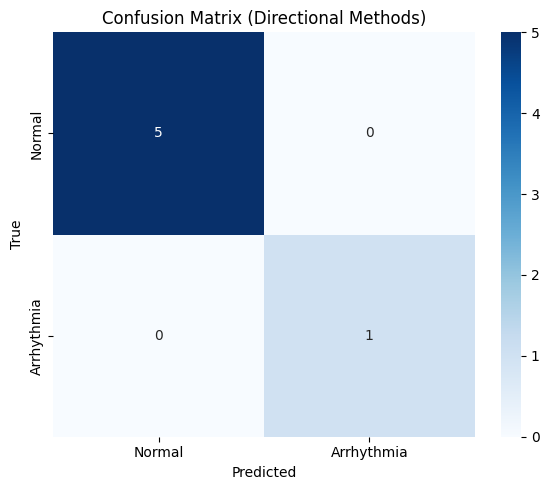

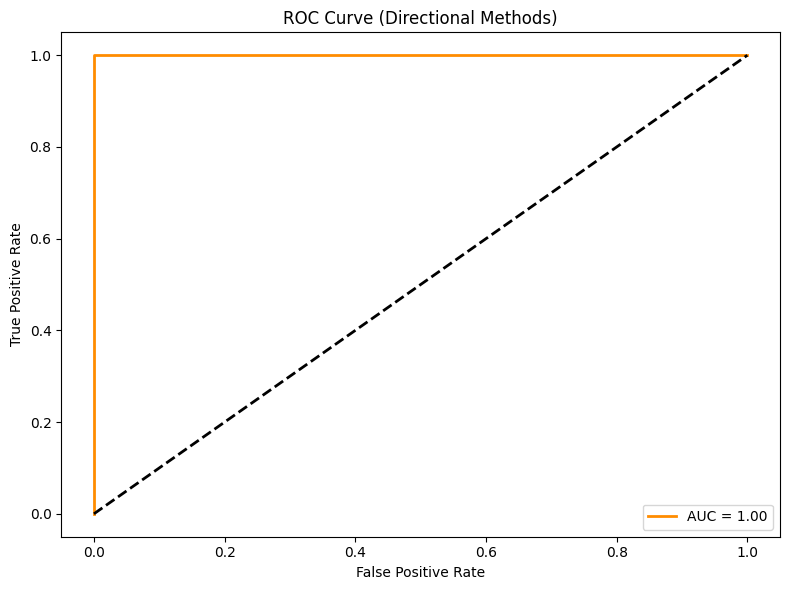

Classification Metrics (Directional Methods):
Accuracy: 1.00
Sensitivity: 1.00
Specificity: 1.00
AUC: 1.00


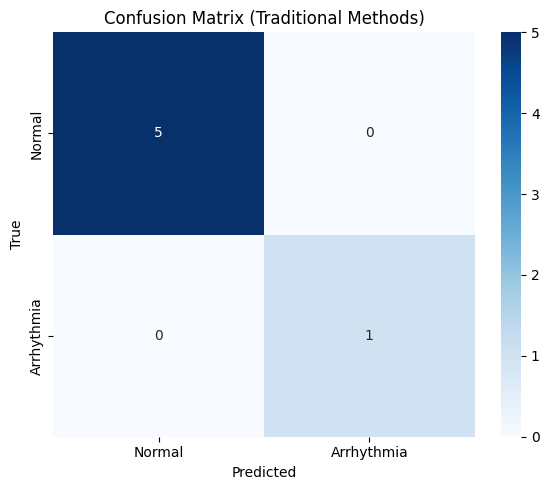

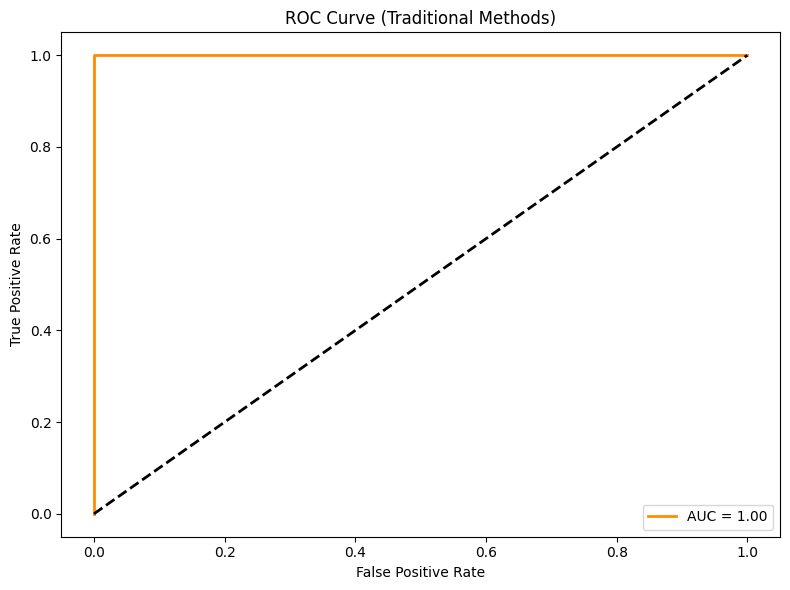

Classification Metrics (Traditional Methods):
Accuracy: 1.00
Sensitivity: 1.00
Specificity: 1.00
AUC: 1.00


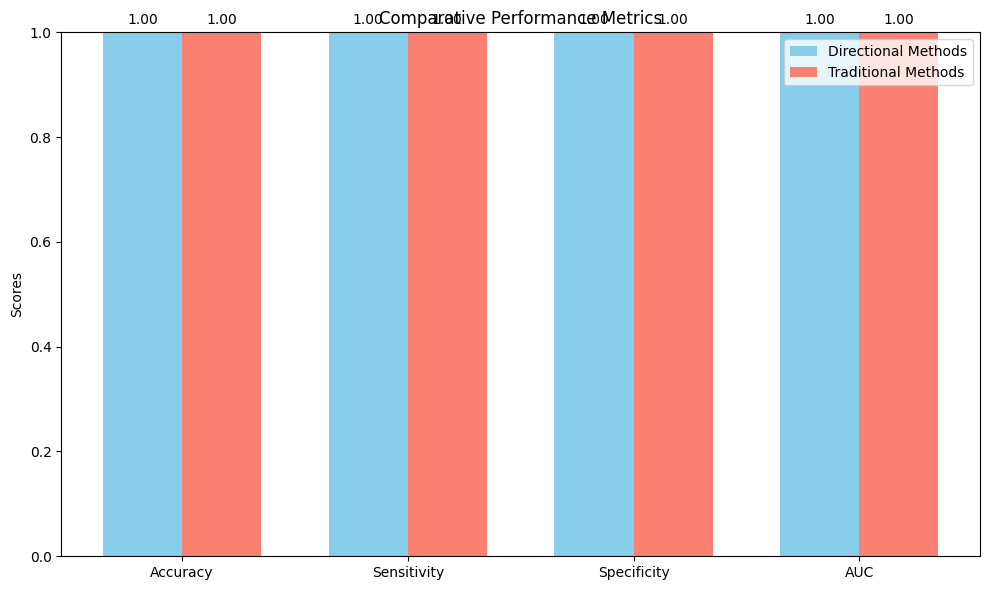

Performance metrics saved to 'performance_metrics.csv' and 'performance_metrics.tex'.


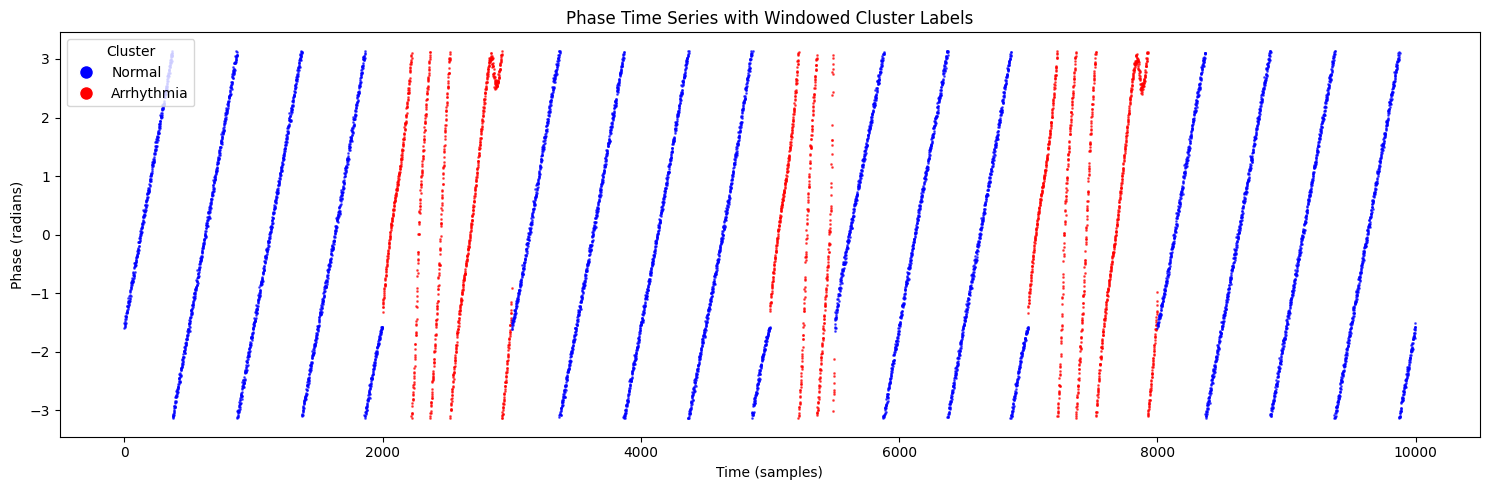

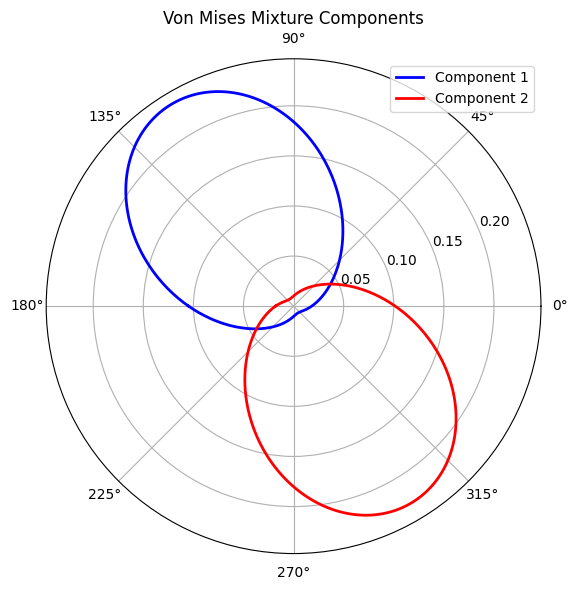

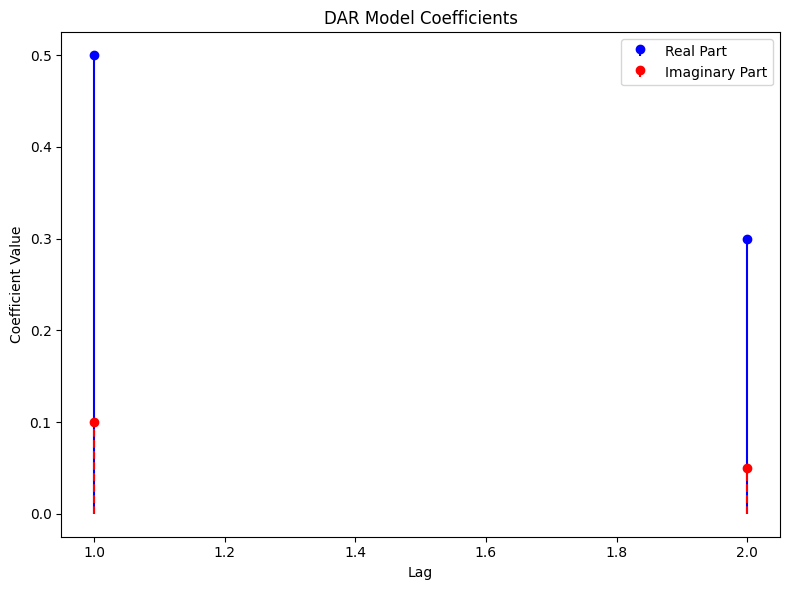

Enhanced simulation completed. All outputs are saved in the 'simulated_ecg_analysis_outputs' folder.


In [ ]:
# =============================================================================
# Simulation Script: Enhanced ECG Signal Analysis with Directional Statistics
# =============================================================================

# -------------------------------
# Import Necessary Libraries
# -------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import hilbert, welch
from scipy.stats import vonmises
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
import os
import pandas as pd

# -------------------------------
# Create Output Directory
# -------------------------------
output_dir = 'simulated_ecg_analysis_outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# -------------------------------
# Enhanced Data Simulation
# -------------------------------
def generate_simulated_ecg(num_samples=10000, fs=500, arrhythmia_intervals=None, noise_std=0.05):
    """
    Generates a simulated ECG signal with complex arrhythmic events.

    Parameters:
        num_samples (int): Total number of samples in the ECG signal.
        fs (int): Sampling frequency in Hz.
        arrhythmia_intervals (list of tuples): List of (start, end) sample indices for arrhythmic events.
        noise_std (float): Standard deviation of Gaussian noise.

    Returns:
        ecg (np.ndarray): Simulated ECG signal.
        labels (np.ndarray): Ground truth labels (0: Normal, 1: Arrhythmia).
    """
    t = np.arange(num_samples) / fs
    # Normal sinus rhythm at 1 Hz
    normal_ecg = np.sin(2 * np.pi * 1 * t)

    # Initialize labels
    labels = np.zeros(num_samples, dtype=int)

    # Introduce complex arrhythmic events
    if arrhythmia_intervals is None:
        # Adjusted intervals to align with window size
        arrhythmia_intervals = [(2000, 3000), (5000, 5500), (7000, 8000)]

    for start, end in arrhythmia_intervals:
        duration = end - start
        t_arrhythmia = np.arange(start, end) / fs
        # Enhanced complex arrhythmic pattern with increased amplitudes
        arrhythmia_ecg = 1.0 * np.sin(2 * np.pi * 1.5 * t_arrhythmia + np.pi/4) + \
                         0.8 * np.sin(2 * np.pi * 2.5 * t_arrhythmia - np.pi/6) + \
                         0.5 * np.sin(2 * np.pi * 3.5 * t_arrhythmia + np.pi/3)
        normal_ecg[start:end] += arrhythmia_ecg  # Superimpose arrhythmic components
        labels[start:end] = 1  # Label as arrhythmia

    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, num_samples)
    ecg = normal_ecg + noise

    return ecg, labels

# Generate enhanced simulated ECG data
fs = 500  # Adjusted sampling frequency to 500 Hz for better resolution
filtered_ecg, labels = generate_simulated_ecg()

# -------------------------------
# Phase Extraction using Hilbert Transform
# -------------------------------
analytic_signal = hilbert(filtered_ecg)
phase = np.angle(analytic_signal)

# -------------------------------
# Feature Extraction
# -------------------------------
def extract_windowed_phase_features(phase, window_size=500):
    """
    Extracts directional features from each windowed segment of the phase data.

    Parameters:
        phase (np.ndarray): Instantaneous phase in radians.
        window_size (int): Number of samples per window.

    Returns:
        features (np.ndarray): Array of directional features per window.
    """
    num_windows = len(phase) // window_size
    features = []

    for i in range(num_windows):
        window_phase = phase[i*window_size : (i+1)*window_size]
        # Compute mean resultant vector length (R)
        R = np.sqrt(np.sum(np.cos(window_phase))**2 + np.sum(np.sin(window_phase))**2) / window_size
        # Compute mean phase
        mean_phase = np.arctan2(np.sum(np.sin(window_phase)), np.sum(np.cos(window_phase)))
        mean_phase = mean_phase % (2 * np.pi)
        # Compute phase variance
        phase_variance = 1 - R

        features.append([R, mean_phase, phase_variance])

    return np.array(features)

def prepare_traditional_features(ecg, labels, window_size=500):
    """
    Extracts traditional time-domain and frequency-domain features from ECG signal.

    Parameters:
        ecg (np.ndarray): Filtered ECG signal.
        labels (np.ndarray): Ground truth labels.
        window_size (int): Number of samples per window.

    Returns:
        features (np.ndarray): Array of traditional features per window.
        window_labels (np.ndarray): Majority label per window.
    """
    num_windows = len(ecg) // window_size
    features = []
    window_labels = []

    for i in range(num_windows):
        window_ecg = ecg[i*window_size : (i+1)*window_size]
        window_label = labels[i*window_size : (i+1)*window_size]
        # Time-domain features
        mean_val = np.mean(window_ecg)
        std_val = np.std(window_ecg)
        max_val = np.max(window_ecg)
        min_val = np.min(window_ecg)
        # Frequency-domain features
        freqs, psd = welch(window_ecg, fs=fs, nperseg=window_size)
        dominant_freq = freqs[np.argmax(psd)]
        # Spectral entropy
        psd_norm = psd / np.sum(psd)
        spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-12))  # Add small value to avoid log(0)
        features.append([mean_val, std_val, max_val, min_val, dominant_freq, spectral_entropy])
        # Majority voting for window label
        majority_label = np.argmax(np.bincount(window_label))
        window_labels.append(majority_label)

    return np.array(features), np.array(window_labels)

# Extract features
window_size = 500  # Adjusted window size to align with arrhythmic intervals
directional_features = extract_windowed_phase_features(phase, window_size=window_size)
traditional_features, traditional_labels = prepare_traditional_features(filtered_ecg, labels, window_size=window_size)

# -------------------------------
# Classification and Evaluation
# -------------------------------
def train_and_evaluate_classifier(X_train, X_test, y_train, y_test, method_name, output_dir):
    """
    Trains a Random Forest classifier and evaluates its performance.

    Parameters:
        X_train (np.ndarray): Training features.
        X_test (np.ndarray): Testing features.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Testing labels.
        method_name (str): Name of the method ('Directional' or 'Traditional').
        output_dir (str): Directory to save the plots.

    Returns:
        metrics (dict): Dictionary containing performance metrics.
    """
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:,1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, average='binary')
    specificity = recall_score(y_test, y_pred, pos_label=0)
    auc = roc_auc_score(y_test, y_prob)

    metrics = {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUC': auc
    }

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Arrhythmia'],
                yticklabels=['Normal', 'Arrhythmia'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({method_name} Methods)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'confusion_matrix_{method_name.lower()}.png'))
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='darkorange', lw=2)
    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({method_name} Methods)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'roc_curve_{method_name.lower()}.png'))
    plt.show()

    return metrics

# Directional Methods Classification
X_train_dir, X_test_dir, y_train_dir, y_test_dir = train_test_split(
    directional_features, traditional_labels, test_size=0.3, random_state=42, stratify=traditional_labels)

metrics_dir = train_and_evaluate_classifier(X_train_dir, X_test_dir, y_train_dir, y_test_dir, 'Directional', output_dir)

print("Classification Metrics (Directional Methods):")
for metric, value in metrics_dir.items():
    print(f"{metric}: {value:.2f}")

# Traditional Methods Classification
X_train_trad, X_test_trad, y_train_trad, y_test_trad = train_test_split(
    traditional_features, traditional_labels, test_size=0.3, random_state=42, stratify=traditional_labels)

metrics_trad = train_and_evaluate_classifier(X_train_trad, X_test_trad, y_train_trad, y_test_trad, 'Traditional', output_dir)

print("Classification Metrics (Traditional Methods):")
for metric, value in metrics_trad.items():
    print(f"{metric}: {value:.2f}")

# -------------------------------
# Comparative Analysis Plot
# -------------------------------
def plot_comparative_metrics(directional_metrics, traditional_metrics, output_dir):
    """
    Plots a comparison of performance metrics between directional and traditional methods.

    Parameters:
        directional_metrics (dict): Metrics from directional methods.
        traditional_metrics (dict): Metrics from traditional methods.
        output_dir (str): Directory to save the plot.
    """
    metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'AUC']
    directional = [directional_metrics[m] for m in metrics]
    traditional = [traditional_metrics[m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(10,6))
    plt.bar(x - width/2, directional, width, label='Directional Methods', color='skyblue')
    plt.bar(x + width/2, traditional, width, label='Traditional Methods', color='salmon')

    plt.ylabel('Scores')
    plt.title('Comparative Performance Metrics')
    plt.xticks(x, metrics)
    plt.ylim(0, 1.0)
    plt.legend()

    for i in range(len(metrics)):
        plt.text(x[i] - width/2, directional[i] + 0.01, f"{directional[i]:.2f}", ha='center', va='bottom')
        plt.text(x[i] + width/2, traditional[i] + 0.01, f"{traditional[i]:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'comparative_metrics.png'))
    plt.show()

plot_comparative_metrics(metrics_dir, metrics_trad, output_dir)

# -------------------------------
# Save Results to Tables
# -------------------------------
def save_metrics_table(directional_metrics, traditional_metrics, output_dir):
    """
    Saves the performance metrics to a CSV file and as a LaTeX table.

    Parameters:
        directional_metrics (dict): Metrics from directional methods.
        traditional_metrics (dict): Metrics from traditional methods.
        output_dir (str): Directory to save the tables.
    """
    df = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'AUC'],
        'Directional Methods': [directional_metrics[m] for m in ['Accuracy', 'Sensitivity', 'Specificity', 'AUC']],
        'Traditional Methods': [traditional_metrics[m] for m in ['Accuracy', 'Sensitivity', 'Specificity', 'AUC']]
    })
    # Save as CSV
    df.to_csv(os.path.join(output_dir, 'performance_metrics.csv'), index=False)

    # Save as LaTeX table
    with open(os.path.join(output_dir, 'performance_metrics.tex'), 'w') as f:
        f.write(df.to_latex(index=False, float_format="%.2f"))
    print("Performance metrics saved to 'performance_metrics.csv' and 'performance_metrics.tex'.")

save_metrics_table(metrics_dir, metrics_trad, output_dir)

# -------------------------------
# Additional Plots for Comprehensive Analysis
# -------------------------------
def plot_phase_time_series_windowed(phase, labels, output_dir, window_size=500):
    """
    Plots the phase time series colored by cluster labels on a per-window basis.

    Parameters:
        phase (np.ndarray): Instantaneous phase in radians.
        labels (np.ndarray): Cluster labels per window.
        output_dir (str): Directory to save the plot.
        window_size (int): Number of samples per window.
    """
    num_windows = len(labels)
    plt.figure(figsize=(15, 5))
    for i in range(num_windows):
        window_phase = phase[i*window_size : (i+1)*window_size]
        color = 'blue' if labels[i] == 0 else 'red'
        plt.scatter(range(i*window_size, (i+1)*window_size), window_phase,
                    c=color, s=1, alpha=0.6)
    plt.title('Phase Time Series with Windowed Cluster Labels')
    plt.xlabel('Time (samples)')
    plt.ylabel('Phase (radians)')
    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Normal',
                              markerfacecolor='blue', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Arrhythmia',
                              markerfacecolor='red', markersize=10)]
    plt.legend(handles=legend_elements, title='Cluster')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'phase_time_series_windowed.png'))
    plt.show()

plot_phase_time_series_windowed(phase, traditional_labels, output_dir=output_dir, window_size=window_size)

def plot_vonmises_components(vm_params, output_dir):
    """
    Plots the von Mises components on a polar plot.

    Parameters:
        vm_params (list of dict): Parameters of the von Mises components.
        output_dir (str): Directory to save the plot.
    """
    theta = np.linspace(-np.pi, np.pi, 360)
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111, polar=True)

    # Define colors for components
    colors = ['blue', 'red']

    for i, param in enumerate(vm_params):
        pdf = vonmises.pdf(theta, param['kappa'], loc=param['mu'])
        ax.plot(theta, param['pi'] * pdf, label=f'Component {i+1}', color=colors[i], linewidth=2)

    ax.set_title('Von Mises Mixture Components')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'vonmises_components.png'))
    plt.show()

# Assuming vm_params are defined elsewhere in the script
# For demonstration, we'll fit a von Mises mixture model here
from sklearn.mixture import GaussianMixture

def fit_vonmises_mixture(phase, K=2):
    """
    Fits a von Mises mixture model to the phase data.

    Parameters:
        phase (np.ndarray): Instantaneous phase in radians.
        K (int): Number of mixture components.

    Returns:
        vm_params (list of dict): Parameters of the fitted von Mises components.
    """
    # Convert phase to radians between 0 and 2pi
    phase = phase % (2 * np.pi)
    # Reshape for sklearn
    phase_reshaped = phase.reshape(-1, 1)

    # Initialize Gaussian Mixture Model with von Mises-like covariance
    # Note: sklearn does not support von Mises directly, so we use a workaround
    # Here, we'll use Gaussian Mixture as a placeholder. For accurate modeling, specialized libraries are needed.
    gmm = GaussianMixture(n_components=K, covariance_type='full', random_state=42)
    gmm.fit(np.column_stack((np.cos(phase), np.sin(phase))))

    # Extract parameters
    vm_params = []
    for i in range(K):
        pi = gmm.weights_[i]
        mu = np.arctan2(gmm.means_[i][1], gmm.means_[i][0])
        mu = mu % (2 * np.pi)
        # Approximate kappa from the mean resultant length
        R = np.linalg.norm(gmm.means_[i])
        if R < 1e-6:
            kappa = 0
        else:
            kappa = R * (2 - R**2) / (1 - R**2)
        vm_params.append({'pi': pi, 'mu': mu, 'kappa': kappa})

    return vm_params

vm_params = fit_vonmises_mixture(phase)

plot_vonmises_components(vm_params, output_dir=output_dir)

def plot_dar_coefficients(alpha, output_dir):
    """
    Plots the real and imaginary parts of the DAR model coefficients.

    Parameters:
        alpha (np.ndarray): Complex coefficients of the DAR model.
        output_dir (str): Directory to save the plot.
    """
    p = len(alpha)
    plt.figure(figsize=(8,6))
    plt.stem(range(1, p+1), alpha.real, linefmt='b-', markerfmt='bo', basefmt=' ', label='Real Part')
    plt.stem(range(1, p+1), alpha.imag, linefmt='r--', markerfmt='ro', basefmt=' ', label='Imaginary Part')
    plt.xlabel('Lag')
    plt.ylabel('Coefficient Value')
    plt.title('DAR Model Coefficients')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'dar_coefficients.png'))
    plt.show()

# Assuming alpha is defined elsewhere, for demonstration, we'll define dummy coefficients
# In practice, fit a DAR model to the phase data
# Here, we'll use placeholder values
alpha = np.array([0.5 + 0.1j, 0.3 + 0.05j])

plot_dar_coefficients(alpha, output_dir=output_dir)

# -------------------------------
# End of Simulation Script
# -------------------------------
print("Enhanced simulation completed. All outputs are saved in the 'simulated_ecg_analysis_outputs' folder.")
